# Box Convolutional Denoising of Tiny Imagenet with AWGN

## Setup

In [4]:
! [ -d box-convolutional-denoising ] || git clone https://github.com/sdll/box-convolutional-denoising.git

Cloning into 'box-convolutional-denoising'...
remote: Enumerating objects: 101, done.
remote: Counting objects: 100% (101/101), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 101 (delta 42), reused 86 (delta 33), pack-reused 0
Receiving objects: 100% (101/101), 69.72 KiB | 721.00 KiB/s, done.
Resolving deltas: 100% (42/42), done.


In [3]:
%cd box-convolutional-denoising/examples/noisy-tiny-imagenet

/content/box-convolutional-denoising/examples/noisy-tiny-imagenet


In [6]:
! wget http://cs231n.stanford.edu/tiny-imagenet-200.zip

--2020-01-18 20:13:28--  http://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.68.10
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘tiny-imagenet-200.zip’

tiny-imagenet-200.z 100%[===================>] 236.61M  19.6MB/s    in 15s     

2020-01-18 20:13:44 (15.9 MB/s) - ‘tiny-imagenet-200.zip’ saved [248100043/248100043]



In [0]:
! unzip -qq tiny-imagenet-200.zip

In [8]:
!pip install -q gsheet-keyring ipython-secrets comet_ml tqdm

     |████████████████████████████████| 2.3MB 15.0MB/s 


In [9]:
!python3 -m pip install --force-reinstall git+https://github.com/sdll/box-convolutional-denoising.git

  Cloning https://github.com/sdll/box-convolutional-denoising.git to /tmp/pip-req-build-gbackhpr
  Running command git clone -q https://github.com/sdll/box-convolutional-denoising.git /tmp/pip-req-build-gbackhpr
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 829kB 8.4MB/s 
     |████████████████████████████████| 773.1MB 20kB/s 
     |████████████████████████████████| 20.2MB 161kB/s 
  Created wheel for box-convolution: filename=box_convolution-0.0.0-cp36-cp36m-linux_x86_64.whl size=4044469 sha256=c38935c58afd4a5520e2ec89bc3356d6011dcbe78a65aa0f295b1d0acad5cafa
  Stored in directory: /tmp/pip-ephem-wheel-cache-b4e5oho1/wheels/c2/96/64/b3ec1b1ff27c74f22ff8251bb0c8cf0b8114c937b060d95133
Successfully built box-convolution
  Created wheel for future: filename=future-0.18.2-cp36-none-any.whl size=491057 sha256=91b4cf13c2c36ff07e76d72191bc3ea87ee1344088f0683d3ca7ed7b38da932e


### Imports

In [0]:
from comet_ml import Experiment

import torch
import argparse
from torch import nn
from torch import optim

from ipython_secrets import get_secret
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader

sns.set()


from tqdm import tqdm as tqdm_base
def tqdm(*args, **kwargs):
    if hasattr(tqdm_base, '_instances'):
        for instance in list(tqdm_base._instances):
            tqdm_base._decr_instances(instance)
    return tqdm_base(*args, **kwargs)

from pytorch_ssim import ssim

from dataset import NoisyTinyImagenet
from model import BoxDnCNN

In [2]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 99999;

<IPython.core.display.Javascript object>

### Environment

In [0]:
PROJECT = "fastrino"
DEVICE = "cuda"
DATA_PATH = "./tiny-imagenet-200/"
COMET_ML_API_KEY = get_secret("comet-{}".format(PROJECT))

## Utilities

In [0]:
def load_noisy_data(noise_mean=0, noise_std=1, batch_size=32):
    train_data = NoisyTinyImagenet(DATA_PATH, split="train", noise_mean=noise_mean, noise_std=noise_std)
    test_data = NoisyTinyImagenet(DATA_PATH, split="test", noise_mean=noise_mean, noise_std=noise_std)

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

def get_arg_parser():
    parser = argparse.ArgumentParser()
    parser.add_argument("--in-channels", type=int, default=3)
    parser.add_argument("--out-features", type=int, default=32)
    parser.add_argument("--num-blocks", type=int, default=4)
    parser.add_argument("--num-boxes", type=int, default=4)
    parser.add_argument("--max-input-h", type=int, default=64)
    parser.add_argument("--max-input-w", type=int, default=64)
    parser.add_argument("--lr", type=float, default=1e-4)
    parser.add_argument("--batch-size", type=int, default=16)
    parser.add_argument("--noise-mean", type=float, default=0)
    parser.add_argument("--noise-std", type=int, default=0.1)
    parser.add_argument("--num-epochs", type=int, default=5)
    parser.add_argument("--seed", type=int, default=42)

    return parser


def get_criterion():
    return nn.MSELoss()


def get_optimizer(model, lr=0.001):
    return optim.Adam(model.parameters(), lr)


def psnr(prediction, target, max_pixel=255.0):
    return (
        10.0 * ((max_pixel ** 2) / ((prediction - target) ** 2).mean()).log10()
    )
    

def train(noise_mean=0, noise_std=0.01, device=DEVICE):
    parser = get_arg_parser()
    args = parser.parse_args(args=[])
    args.noise_mean = noise_mean
    args.noise_std = noise_std
    train_loader, test_loader = load_noisy_data(
        args.noise_mean, args.noise_std, args.batch_size
    )
    experiment = Experiment(
        api_key=COMET_ML_API_KEY,
        project_name=PROJECT,
        workspace=PROJECT,
        auto_output_logging=None,
    )
    experiment.log_parameters(vars(args))

    model = BoxDnCNN(
        args.in_channels,
        args.out_features,
        args.num_blocks,
        args.num_boxes,
        args.max_input_h,
        args.max_input_w
    ).to(device)

    criterion = get_criterion()
    optimizer = get_optimizer(model, args.lr)

    for epoch in tqdm(
        range(args.num_epochs), desc="Epoch", unit="epochs"
    ):
        with experiment.train():
            model.train()
            train_psnr = []
            train_ssim = []

            for image, noise in tqdm(
                train_loader, desc="Train images", unit="images"
            ):
                image = image.to(device)
                noise = noise.to(device)
                
                prediction = model(image)
                loss = criterion(prediction, noise)

                loss.backward()
                optimizer.step()
                optimizer.zero_grad()

                current_psnr = psnr(image - prediction, image - noise).data.item()
                current_ssim = ssim(image - prediction, image - noise).data.item()                
                train_psnr.append(current_psnr)
                train_ssim.append(current_ssim)
                experiment.log_metric("psnr", current_psnr)
                experiment.log_metric("ssim", current_ssim)
                experiment.log_metric("loss", loss.data.item())
            

            experiment.log_metric("mean_psnr", np.mean(train_psnr))
            experiment.log_metric("mean_ssim", np.mean(train_ssim))

    with experiment.test():
        model.eval()
        test_losses = []
        test_psnr = []
        test_ssim = []
        for image, noise in test_loader:
            image = image.to(device)
            noise = noise.to(device)
            prediction = model(image)
            current_psnr = psnr(image - prediction, image - noise).data.item()
            current_ssim = ssim(image - prediction, image - noise).data.item()                
            test_psnr.append(current_psnr)
            test_ssim.append(current_ssim)            
            test_losses.append(
                criterion(prediction, noise).data.item()
            )

        test_psnr = np.mean(test_psnr)
        test_ssim = np.mean(test_ssim)
        test_loss = np.mean(test_losses)

        experiment.log_metric("mean_psnr", test_psnr)
        experiment.log_metric("mean_ssim", test_ssim)
        experiment.log_metric("mean_loss", test_loss)
        
    return test_psnr, test_ssim, test_loss

## Training

In [12]:
noise_mean = np.linspace(0.01, 0.5, 3)
noise_std = np.linspace(0.01, 0.5, 3)

index = pd.MultiIndex.from_product(
    [noise_mean, noise_std],
    names = ["noise_mean", "noise_std"]
)
results = pd.DataFrame(index = index).reset_index()
results["test_psnr"] = 0.0
results["test_ssim"] = 0.0
results["test_loss"] = 0.0
results.head()

,noise_mean,noise_std,test_psnr,test_ssim,test_loss
0,0.010,0.010,0.0,0.0,0.0
1,0.010,0.255,0.0,0.0,0.0
2,0.010,0.500,0.0,0.0,0.0
3,0.255,0.010,0.0,0.0,0.0
4,0.255,0.255,0.0,0.0,0.0


In [13]:
for (idx, row) in results.iterrows():
    noise_mean, noise_std, *_ = row
    test_psnr, test_ssim, test_loss = train(noise_mean, noise_std, device=DEVICE)
    row[2] = test_psnr
    row[3] = test_ssim
    row[4] = test_loss

COMET INFO: Experiment is live on comet.ml https://www.comet.ml/fastrino/fastrino/05c13102da5f4c6fa61ca49cc5021616

Epoch: 100%|██████████| 5/5 [15:35<00:00, 189.88s/epochs]
COMET INFO: ----------------------------
COMET INFO: Comet.ml Experiment Summary:
COMET INFO:   Data:
COMET INFO:     url: https://www.comet.ml/fastrino/fastrino/05c13102da5f4c6fa61ca49cc5021616
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     sys.cpu.percent.01                  : (6.4, 6.4)
COMET INFO:     sys.cpu.percent.02                  : (1.8, 1.8)
COMET INFO:     sys.cpu.percent.avg                 : (4.1000000000000005, 4.1000000000000005)
COMET INFO:     sys.gpu.0.free_memory               : (15812198400.0, 15812198400.0)
COMET INFO:     sys.gpu.0.gpu_utilization           : (0.0, 0.0)
COMET INFO:     sys.gpu.0.total_memory              : (15812263936.0, 15812263936.0)
COMET INFO:     sys.gpu.0.used_memory               : (65536.0, 65536.0)
COMET INFO:     sys.ram.total                       : (1

In [14]:
results

,noise_mean,noise_std,test_psnr,test_ssim,test_loss
0,0.010,0.010,89.435880,0.991220,0.000074
1,0.010,0.255,68.213247,0.630569,0.009840
2,0.010,0.500,65.661396,0.474659,0.017714
3,0.255,0.010,88.695017,0.989378,0.000088
4,0.255,0.255,68.193097,0.633278,0.009886
5,0.255,0.500,65.858975,0.487350,0.016935
6,0.500,0.010,88.530195,0.988890,0.000091
7,0.500,0.255,68.319974,0.634254,0.009605
8,0.500,0.500,65.724719,0.486540,0.017462


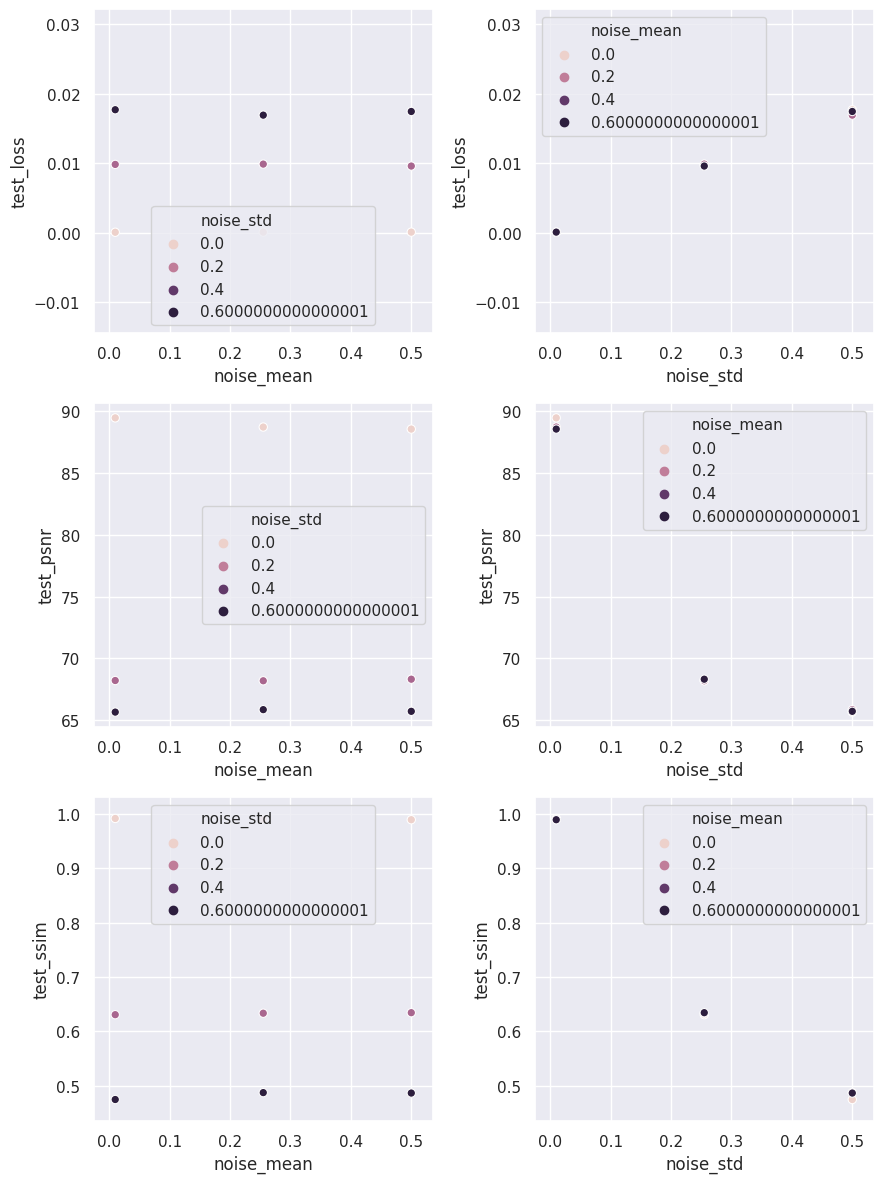

In [19]:
plt.figure(dpi=100, figsize=(9, 12))
plt.subplot(3, 2, 1)
sns.scatterplot(x=results["noise_mean"], hue=results["noise_std"], y=results["test_loss"])
plt.subplot(3, 2, 2)
sns.scatterplot(x=results["noise_std"], hue=results["noise_mean"], y=results["test_loss"])
plt.subplot(3, 2, 3)
sns.scatterplot(x=results["noise_mean"], hue=results["noise_std"], y=results["test_psnr"])
plt.subplot(3, 2, 4)
sns.scatterplot(x=results["noise_std"], hue=results["noise_mean"], y=results["test_psnr"])
plt.subplot(3, 2, 5)
sns.scatterplot(x=results["noise_mean"], hue=results["noise_std"], y=results["test_ssim"])
plt.subplot(3, 2, 6)
sns.scatterplot(x=results["noise_std"], hue=results["noise_mean"], y=results["test_ssim"])
plt.tight_layout()
plt.show()